<a href="https://colab.research.google.com/github/dp1500/Algorithmic-Trading/blob/main/RSI_%26_Bollinger_AAPL_DAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('HistoricalQuotes.csv')


In [3]:
print(df["Close"].dtype)

float64


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

In [5]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.86,137312041,29.3928,29.9286,29.3500
2010-03-02,29.84,141486282,29.9900,30.1186,29.6771
2010-03-03,29.90,92846488,29.8486,29.9814,29.7057
2010-03-04,30.10,89591907,29.8971,30.1314,29.8043
2010-03-05,31.28,224647427,30.7057,31.3857,30.6614
...,...,...,...,...,...
2020-02-24,298.18,55548830,297.2600,304.1800,289.2300
2020-02-25,288.08,57668360,300.9500,302.5300,286.1300
2020-02-26,292.65,49678430,286.5300,297.8800,286.5000


In [6]:
df.columns

Index(['Close', ' Volume', 'Open', 'High', 'Low'], dtype='object')

In [7]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df[' Volume'] = pd.to_numeric(df[' Volume'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')


In [8]:
print(df["Close"].dtype)

float64


In [9]:
print(df.head())
print(df['Close'].dtype)

            Close     Volume     Open     High      Low
Date                                                   
2010-03-01  29.86  137312041  29.3928  29.9286  29.3500
2010-03-02  29.84  141486282  29.9900  30.1186  29.6771
2010-03-03  29.90   92846488  29.8486  29.9814  29.7057
2010-03-04  30.10   89591907  29.8971  30.1314  29.8043
2010-03-05  31.28  224647427  30.7057  31.3857  30.6614
float64


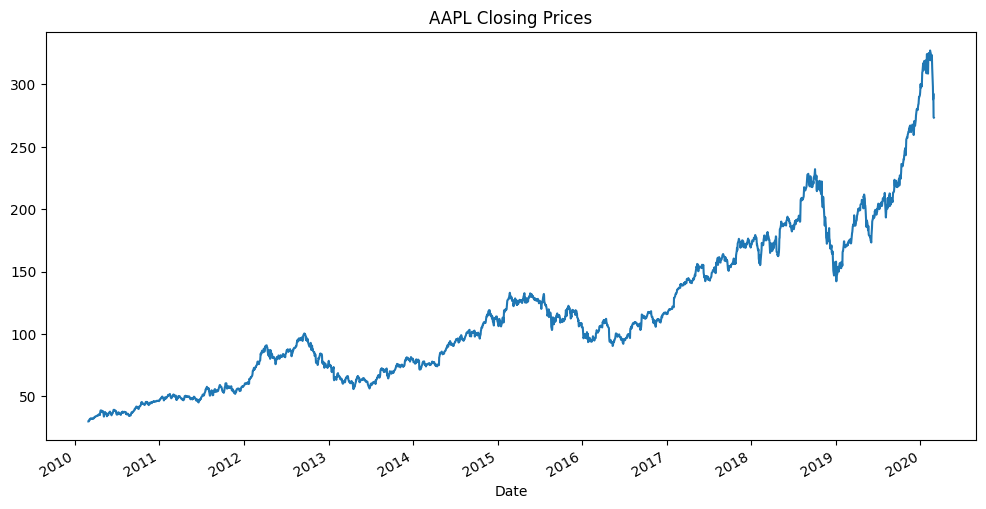

In [10]:
# Plot closing prices
df['Close'].plot(figsize=(12,6))
plt.title('AAPL Closing Prices')
plt.show()

## Implement RSI over bollinger

In [11]:
# creating dataframes copies to fing optimum average periods
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()

## Setup and Calculation

In [18]:
import pandas as pd

# Calculate the Bollinger Bands
df['20_day_MA'] = df['Close'].rolling(window=20).mean()
df['20_day_STD'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['20_day_MA'] + (df['20_day_STD'] * 2)
df['Lower_Band'] = df['20_day_MA'] - (df['20_day_STD'] * 2)

# Compute RSI
delta = df['Close'].diff(1)
gain = delta.where(delta > 0).fillna(0)
loss = -delta.where(delta < 0).fillna(0)
avg_gain = gain.rolling(window=7).mean()
avg_loss = loss.rolling(window=7).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))


## Generate Buy and Sell Signals

In [19]:
# Create a signal column initialized to 0
df['Signal'] = 0.0

# Buy signals
df.loc[(df['Close'] < df['Lower_Band']) & (df['RSI'] < 30), 'Signal'] = 1.0

# Sell signals
df.loc[(df['Close'] > df['Upper_Band']) & (df['RSI'] > 70), 'Signal'] = -1.0


## Implement and Backtest the Strategy

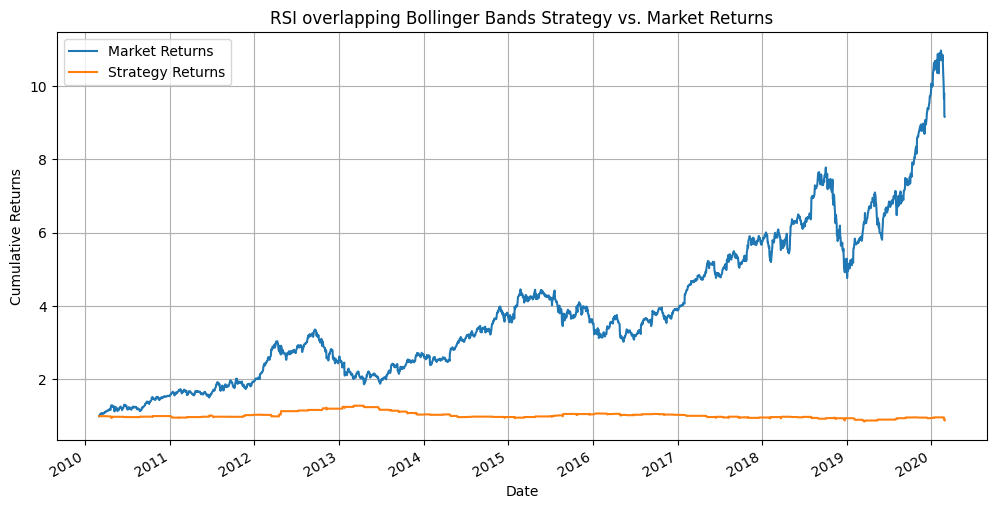

In [20]:
# Calculate daily strategy returns
df['Daily_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Signal'].shift(1) * df['Daily_Return']

# Calculate cumulative returns
cumulative_strategy_returns = (df['Strategy_Return'] + 1).cumprod()
cumulative_market_returns = (df['Daily_Return'] + 1).cumprod()

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
cumulative_market_returns.plot(label='Market Returns', legend=True)
cumulative_strategy_returns.plot(label='Strategy Returns', legend=True)
plt.title('RSI overlapping Bollinger Bands Strategy vs. Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


## metrics

In [21]:
cumulative_strategy_returns = (df['Strategy_Return'] + 1).cumprod()
cumulative_market_returns = (df['Daily_Return'] + 1).cumprod()

final_cumulative_strategy_return = cumulative_strategy_returns.iloc[-1] - 1
final_cumulative_market_return = cumulative_market_returns.iloc[-1] - 1

print(f"Final Cumulative Strategy Return: {final_cumulative_strategy_return:.2%}")
print(f"Final Cumulative Market Return: {final_cumulative_market_return:.2%}")



Final Cumulative Strategy Return: -11.32%
Final Cumulative Market Return: 815.47%


In [22]:
# import pandas as pd
from scipy.stats import skew, kurtosis

def print_strategy_metrics(df):
    # Max Drawdown
    def max_drawdown(returns_series):
        cumulative_returns = (1 + returns_series).cumprod()
        rolling_max = cumulative_returns.cummax()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        return drawdowns.min()

    # Cumulative Returns
    final_cumulative_strategy_return = (df['Strategy_Return'] + 1).cumprod().iloc[-1] - 1
    final_cumulative_market_return = (df['Daily_Return'] + 1).cumprod().iloc[-1] - 1

    # Annualized Returns
    annualized_strategy_return = (1 + df['Strategy_Return'].mean())**252 - 1
    annualized_market_return = (1 + df['Daily_Return'].mean())**252 - 1

    # Annualized Volatility
    annualized_strategy_volatility = df['Strategy_Return'].std() * (252**0.5)
    annualized_market_volatility = df['Daily_Return'].std() * (252**0.5)

    # Skewness & Kurtosis
    strategy_skewness = skew(df['Strategy_Return'].dropna())
    strategy_kurtosis = kurtosis(df['Strategy_Return'].dropna())

    # VaR (95% one-day VaR)
    var_95 = df['Strategy_Return'].quantile(0.05)


    # Sharpe Ratio
    risk_free_rate = 0.0
    sharpe_ratio = (annualized_strategy_return - risk_free_rate) / annualized_strategy_volatility

    # Sortino Ratio
    downside_volatility = df[df['Strategy_Return'] < 0]['Strategy_Return'].std() * (252**0.5)
    sortino_ratio = (annualized_strategy_return - risk_free_rate) / downside_volatility

    # Beta
    cov_matrix = df[['Strategy_Return', 'Daily_Return']].cov()
    beta = cov_matrix.iloc[0, 1] / df['Daily_Return'].var()

    # Print Metrics
    print(f"Final Cumulative Strategy Return: {final_cumulative_strategy_return:.2%}")
    print(f"Final Cumulative Market Return: {final_cumulative_market_return:.2%}")
    print(f"Annualized Strategy Return: {annualized_strategy_return:.2%}")
    print(f"Annualized Market Return: {annualized_market_return:.2%}")
    print(f"Annualized Strategy Volatility: {annualized_strategy_volatility:.2%}")
    print(f"Annualized Market Volatility: {annualized_market_volatility:.2%}")
    print(f"Strategy Max Drawdown: {max_drawdown(df['Strategy_Return']):.2%}")
    print(f"Strategy Skewness: {strategy_skewness:.2f}")
    print(f"Strategy Kurtosis: {strategy_kurtosis:.2f}")
    print(f"Strategy 95% 1-day VaR: {var_95:.2%}")
    print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Strategy Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Strategy Beta: {beta:.2f}")


# Call the function
print_strategy_metrics(df)


Final Cumulative Strategy Return: -11.32%
Final Cumulative Market Return: 815.47%
Annualized Strategy Return: -0.80%
Annualized Market Return: 29.06%
Annualized Strategy Volatility: 8.99%
Annualized Market Volatility: 25.83%
Strategy Max Drawdown: -33.34%
Strategy Skewness: 2.25
Strategy Kurtosis: 62.26
Strategy 95% 1-day VaR: -0.06%
Strategy Sharpe Ratio: -0.09
Strategy Sortino Ratio: -0.05
Strategy Beta: 0.05


In [23]:
df["Signal"].value_counts()

 0.0    2266
-1.0     158
 1.0      94
Name: Signal, dtype: int64